In [50]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_by_day
from peak_id import (
    reshape_by_day, timedelta, topo_argmax, gamma_matrix,
    assert_partition, manual_clustering,
    identify_worst_days
)

ImportError: cannot import name 'identify_worst_days' from 'peak_id' (/home/sean/code/study-hard/renewable_energy/project2/peak_id.py)

In [2]:
time, load, solar_pu = load_by_day(0, 366)
time = time / 60  # Convert to hours!
dt = timedelta(time)

In [3]:
time_per_day, load_per_day, solar_pu_per_day = reshape_by_day(
    time, load, solar_pu
)
timesteps_per_day = time_per_day.shape[1]

In [4]:
# Integrate solar output over the course of the day.
gamma = gamma_matrix(timesteps_per_day, dt)
energy_solar_per_day = solar_pu_per_day @ gamma.T

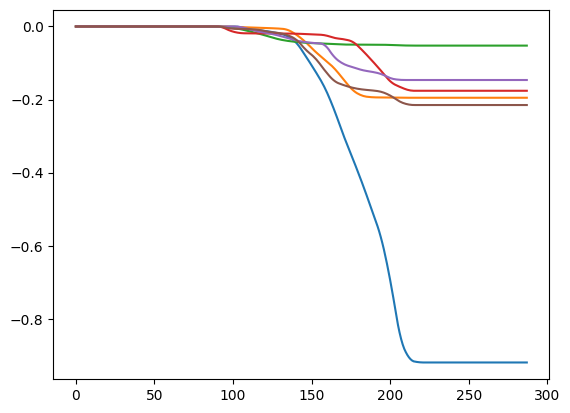

In [5]:
# for i in np.argwhere(solar_num_less_than == 0):
for i in topo_argmax(energy_solar_per_day):
    plt.plot(energy_solar_per_day[i])


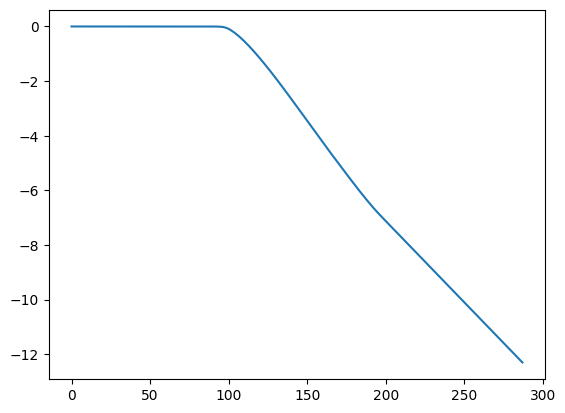

In [6]:
# We've got an issue with the solar data for the last days of the year!!
plt.plot(energy_solar_per_day[365])

In [8]:
# Order by peak load and minimum daily solar generation.
peak_loads = np.max(load_per_day, axis=-1)
daily_solar = np.min(energy_solar_per_day, axis=-1)
problem_days = topo_argmax(np.c_[
    peak_loads, daily_solar
])

In [9]:
problem_days

array([ 76, 193, 208, 209, 224, 225, 252, 334, 347, 352])

In [10]:
problem_groups = manual_clustering(problem_days, peak_loads, daily_solar)
assert_partition(problem_groups.values(), set(problem_days))

In [11]:
daily_solar[problem_groups['low_load_low_solar']]

array([-0.05235714, -0.28557703, -0.14651401, -0.215007  ])

In [12]:
problem_groups

{'low_load_low_solar': array([ 76, 334, 347, 352]),
 'medium_load_low_solar': array([193]),
 'medium_load_medium_solar': array([252]),
 'high_load_cloudy': array([224, 225]),
 'high_load_sunny': array([208, 209])}

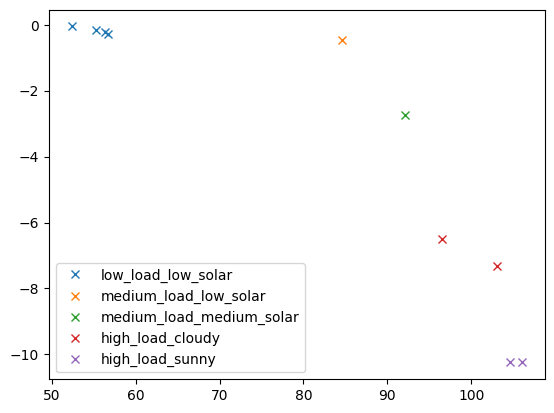

In [13]:
for name, group in problem_groups.items():
    plt.plot(peak_loads[group], daily_solar[group], 'x', label=name)
plt.legend()

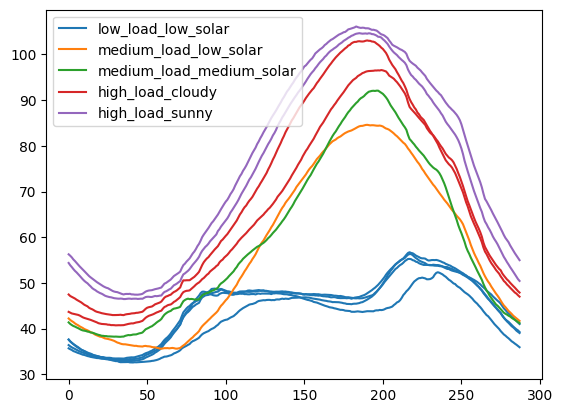

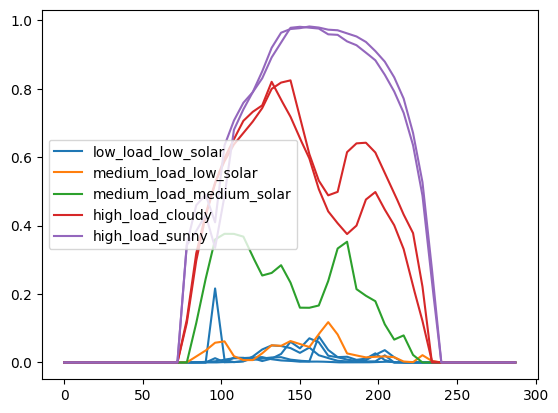

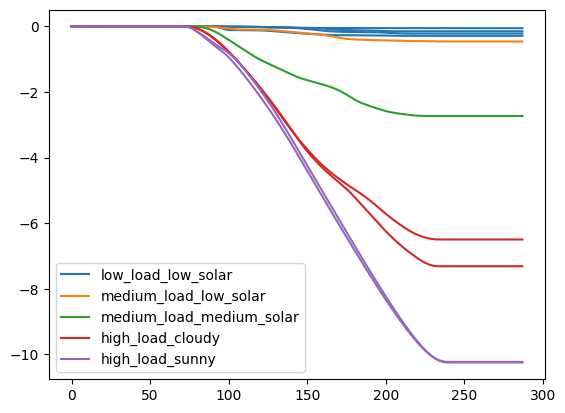

In [14]:
def plot_by_group(y, groups):
    handles = []
    labels = []
    for i, (name, group) in enumerate(groups.items()):
        lines = plt.plot(y[group].T, label=name, color=f"C{i}")
        if lines:
            handles.append(lines[0])
            labels.append(name)
    plt.legend(handles, labels)
    
plt.figure()
plot_by_group(load_per_day, problem_groups)
plt.figure()
plot_by_group(solar_pu_per_day, problem_groups)
plt.figure()
plot_by_group(energy_solar_per_day, problem_groups)


In [40]:
# def worst_case_by_group(problem_groups, load_per_day, energy_solar_per_day):
#     worst_load = {
#         name: np.max(load_per_day[group], axis=0)
#         for name, group in problem_groups.items()
#     }
#     worst_solar = {
#         name: np.max(energy_solar_per_day[group], axis=0)
#         for name, group in problem_groups.items()
#     }
#     return worst_load, worst_solar

In [41]:
worst_load, worst_solar_energy = worst_case_by_group(problem_groups, load_per_day, energy_solar_per_day)

In [42]:
worst_solar_energy.keys()

dict_keys(['low_load_low_solar', 'medium_load_low_solar', 'medium_load_medium_solar', 'high_load_cloudy', 'high_load_sunny'])

In [43]:
worst_solar_energy['low_load_low_solar'].shape

(288,)

In [44]:
gamma

array([[-0.08333333,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08333333, -0.08333333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08333333, -0.08333333, -0.08333333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
         0.        ,  0.        ],
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
        -0.08333333,  0.        ],
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
        -0.08333333, -0.08333333]])

In [45]:
np.linalg.inv(gamma).shape

(288, 288)

In [46]:
worst_solar_pu = {
    name: np.linalg.inv(gamma) @ solar_energy
    for name, solar_energy in worst_solar_energy.items()
}

In [47]:
load[days]

array([43.38856512, 35.00125495, 37.02614278, 38.85669427])

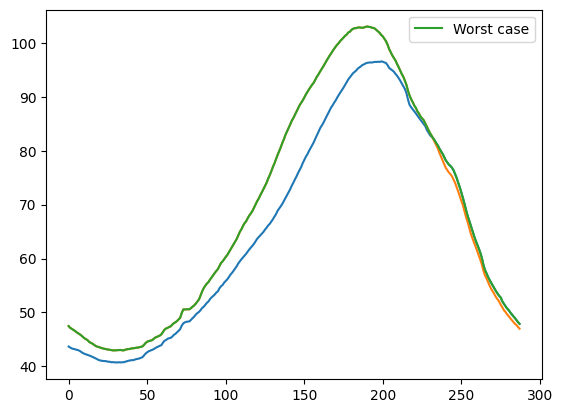

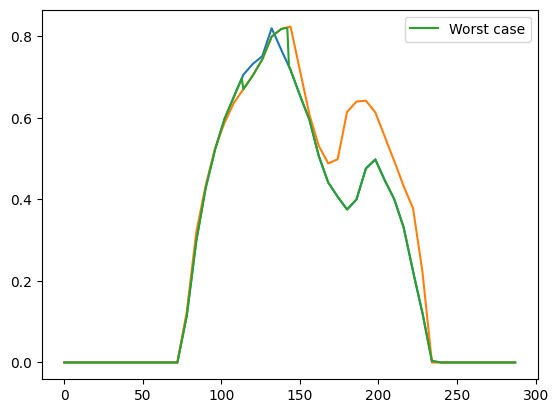

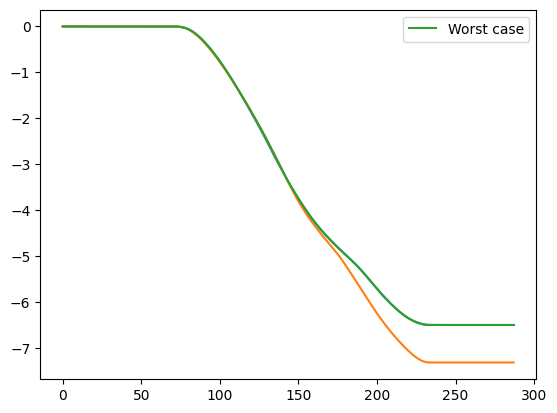

In [49]:
name = 'high_load_cloudy'
days = problem_groups[name]
plt.figure()
plt.plot(load_per_day[days].T)
plt.plot(worst_load[name], label='Worst case')
plt.legend()

plt.figure()
plt.plot(solar_pu_per_day[days].T)
plt.plot(worst_solar_pu[name], label="Worst case")
plt.legend()

plt.figure()
plt.plot(energy_solar_per_day[days].T)
plt.plot(worst_solar_energy[name], label="Worst case")
plt.legend()